# Analyzing experiment from 1/8/2016

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as st
import jetpack
from experiments.iotools import read_channel # from niru-analysis github
from experiments.photodiode import find_peaks, find_start_times
# import binary     # in igor >> recording
import pdb
import string
# from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt
from os.path import expanduser

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## experiment directory

In [2]:
data_dir = '/Users/lmcintosh/experiments/data/16-01-08/'
stim_dir = '/Users/lmcintosh/experiments/data/16-01-08/stimulus/'
stimulus_filename = '16-01-08-stimulus.h5'

## load spikes

In [3]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) for spike in spikes if (not (not spike)) and float(spike) > 0])
    
    text_file.close()

In [4]:
len(cells)

14

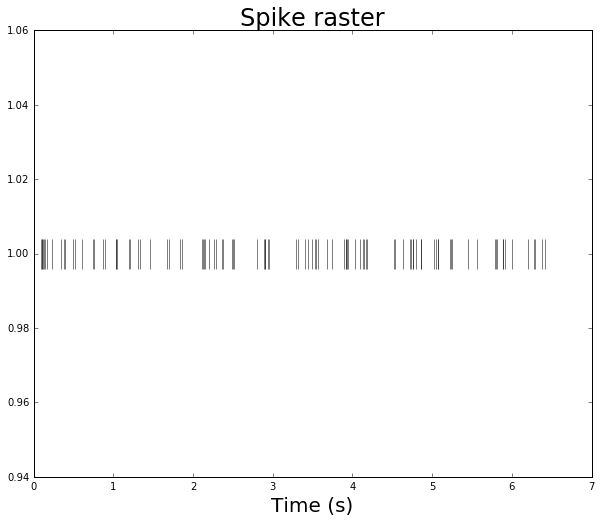

In [5]:
fig = pyviz.raster(cells[0][:100], np.ones((len(cells[0][:100]),)), marker_string='|', color='k', markersize=30)

## load stimulus

In [6]:
f = h5py.File(stim_dir + stimulus_filename)
list(f)

[u'expt1',
 u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt16',
 u'expt17',
 u'expt18',
 u'expt19',
 u'expt2',
 u'expt20',
 u'expt21',
 u'expt22',
 u'expt23',
 u'expt24',
 u'expt3',
 u'expt4',
 u'expt5',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [7]:
list(f['expt1'])

[u'stim', u'timestamps']

In [8]:
(f['expt1/stim'].shape, f['expt1/timestamps'].shape)

((19997, 50, 50), (19997,))

## find peaks in photodiode to align each experiment

#### load photodiode

In [9]:
raw_data = h5py.File(data_dir + '16-1-8.h5')
pd = read_channel(raw_data, channel=0)

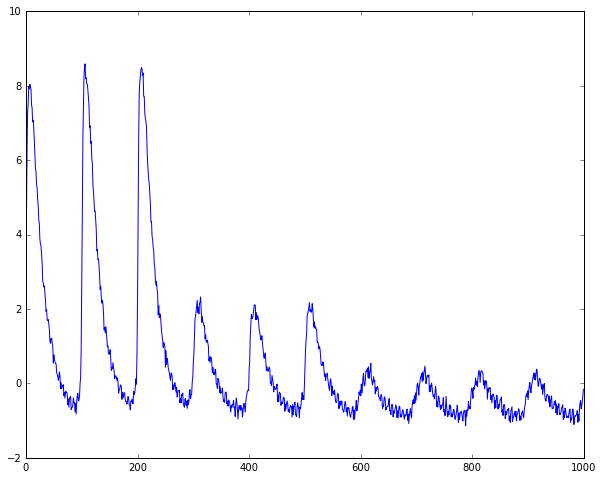

In [10]:
plt.plot(pd[:1000])

#### find peaks

In [92]:
# delta is the threshold for accepting optima; i.e. optima must be delta greater than neighboring values
# delta = 1.0 # this finds all photodiode peaks
# delta = 8.58
delta = 8.58
maxtab = find_peaks(pd, delta)

➛ Finding peaks (can take a minute)... 
Done! ✔


In [93]:
# expectation of maxtab shape is 24 experiments * 3 flips per frame = 72
maxtab.shape

(72, 2)

In [94]:
maxtab[0,:]

array([ 7.        ,  8.03932241])

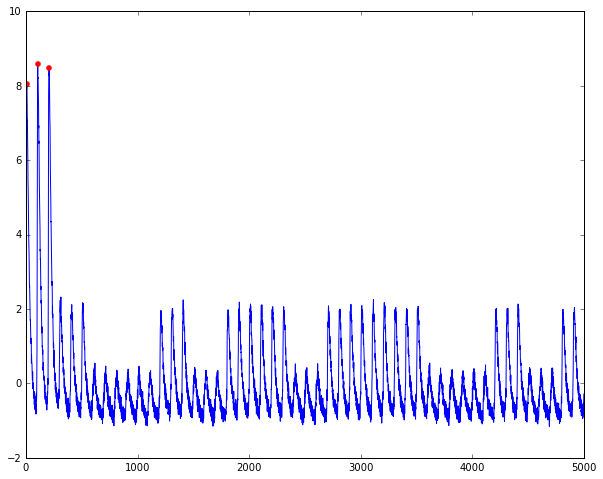

In [95]:
plt.plot(pd[:5000])
# plt.plot(maxtab[:50, 0], maxtab[:50, 1], 'r.', markersize=10)
plt.plot(maxtab[:3, 0], maxtab[:3, 1], 'r.', markersize=10)

In [177]:
# from cycling through threshold-crossings, the 24 expt start times are
maxtab_start_indices = [2, 5, 16, 18, 20, 23, 26, 28, 31, 34, 36, 38, 41, 44, 47, 50, 53, 56, 58, 60, 63, 66, 68, 71]

In [178]:
len(maxtab_start_indices)

24

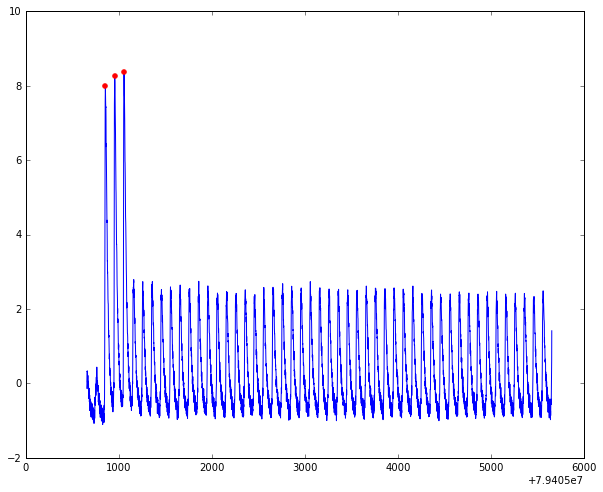

In [176]:
view = int(maxtab[69,0]) - 200
view_end = view + 5000

maxtab_trunc = maxtab[np.bitwise_and(maxtab[:,0] >= view, maxtab[:,0] < view_end), :]

plt.plot(np.linspace(view, view_end, len(pd[view:view_end])), pd[view:view_end], 'b')
plt.plot(maxtab_trunc[:,0], maxtab_trunc[:, 1], 'r.', markersize=10)
# plt.plot(maxtab[:,0], maxtab[:,1], 'k.')

#### Go from maxtab_start_indices to start times in seconds

In [180]:
from jetpack.timepiece import hrtime

In [181]:
sampling_rate = 10e3
refresh_rate = 100
start_times = []

for expt_id, idx in enumerate(maxtab_start_indices):
    pd_idx = maxtab[idx, 0]
  
    # the start times are the times of the last flip in each group (in
    # seconds), plus an offset equal to a single monitor refresh
    # start_times = grouped[:, -1] / sampling_rate + 1 / refresh_rate
    time = pd_idx / sampling_rate + 1 / refresh_rate
    start_times.append(time)
    
print('Found {} different stimulus sequences at the following times:'.format(len(start_times)))
for ix, t in enumerate(start_times):
    print('Stimulus #{:2} started at t = {}'.format(ix+1, hrtime(t)))

Found 24 different stimulus sequences at the following times:
Stimulus # 1 started at t = 20.7 ms
Stimulus # 2 started at t = 10 min., 391.3 ms
Stimulus # 3 started at t = 11 min., 18.1555 s
Stimulus # 4 started at t = 21 min., 29.294 s
Stimulus # 5 started at t = 22 min., 30.3467 s
Stimulus # 6 started at t = 32 min., 30.7475 s
Stimulus # 7 started at t = 33 min., 33.8518 s
Stimulus # 8 started at t = 43 min., 34.4828 s
Stimulus # 9 started at t = 44 min., 34.5549 s
Stimulus #10 started at t = 54 min., 34.8954 s
Stimulus #11 started at t = 55 min., 43.8236 s
Stimulus #12 started at t = 1 hours, 5 min., 55.4623 s
Stimulus #13 started at t = 1 hours, 6 min., 56.0148 s
Stimulus #14 started at t = 1 hours, 16 min., 56.4557 s
Stimulus #15 started at t = 1 hours, 17 min., 56.748 s
Stimulus #16 started at t = 1 hours, 27 min., 57.3591 s
Stimulus #17 started at t = 1 hours, 28 min., 57.431 s
Stimulus #18 started at t = 1 hours, 38 min., 57.7917 s
Stimulus #19 started at t = 1 hours, 40 min., 

In [182]:
f['expt1/timestamps'][-1]

600.32637000000068

# Align spikes with each experiment

In [183]:
expt_spikes = []
for expt_id, start in enumerate(start_times):
    expt_spikes.append([])
    expt_name = 'expt%d' %(expt_id+1)
    stop = f[expt_name + '/timestamps'][-1] # last timestamp, in seconds
    for c in cells:
        expt_spikes[-1].append([sp-start for sp in c if sp >= start and sp <= start+stop])

In [184]:
def spikes_to_array(spikes):
    '''
    Converts a list of spike times to an array with labels for easy
    pyret.visualizations.raster() use.
    
    INPUT:
        spikes    list of list of spike times
    '''
    collapsed_spikes = []
    collapsed_labels = []
    nlists = len(spikes)
    for idl, l in enumerate(spikes):
        labels = idl * np.ones((len(l),))
        collapsed_spikes.extend(l)
        collapsed_labels.extend(labels)
        
    return np.array(collapsed_spikes), np.array(collapsed_labels)
    

In [185]:
all_spikes, all_labels = spikes_to_array(expt_spikes[1])

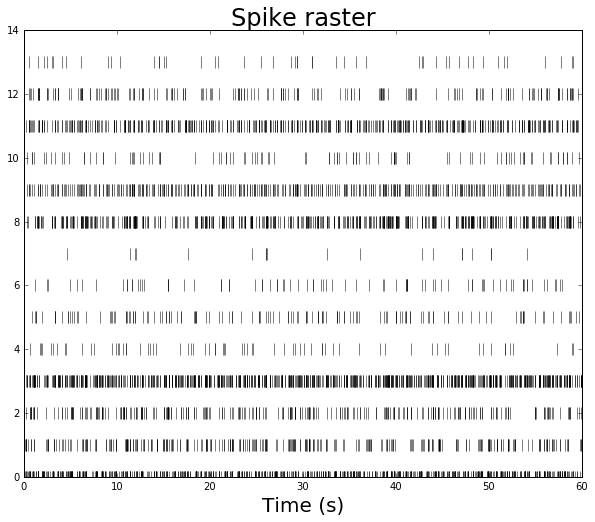

In [186]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

# look at trial-to-trial variability of a single cell to repeated natural movies

In [187]:
cell_idx = 0
first_trial = 7
num_diff_trials = 8
total_trials = 24
repeats = []
for t in range(first_trial, total_trials, num_diff_trials):
    repeats.append(expt_spikes[t][cell_idx])

all_spikes, all_labels = spikes_to_array(repeats)

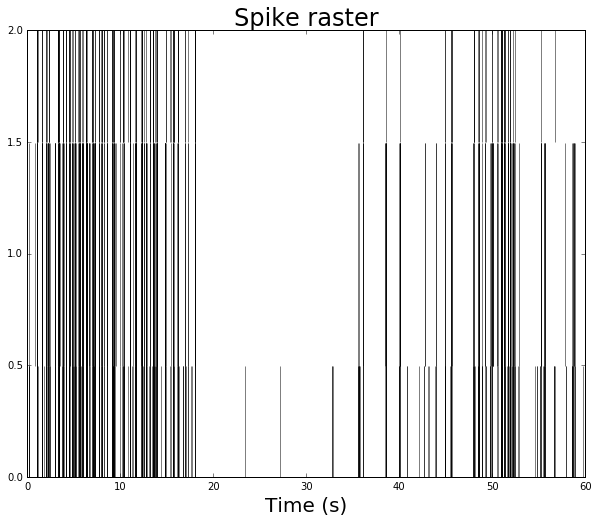

In [188]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=223)

# look at trial-to-trial variability of a single cell to repeated white noise

In [189]:
cell_idx = 0
first_trial = 1
num_diff_trials = 8
total_trials = 24
repeats = []
for t in range(first_trial, total_trials, num_diff_trials):
    repeats.append(expt_spikes[t][cell_idx])

all_spikes, all_labels = spikes_to_array(repeats)

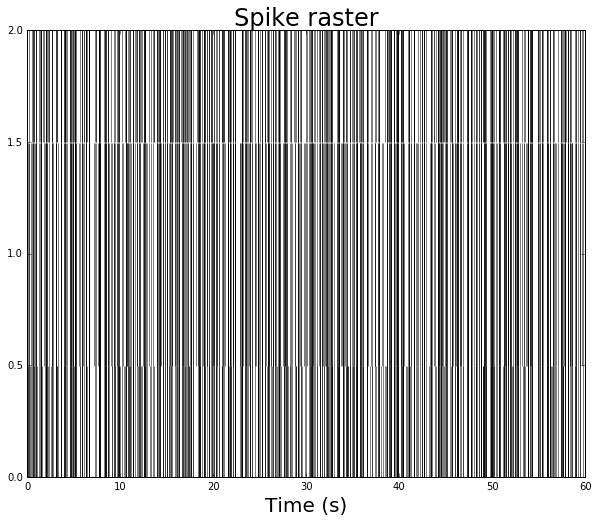

In [190]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=223)

In [191]:
len(cells)

14

In [192]:
import brewer2mpl

In [193]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

(0, 60)

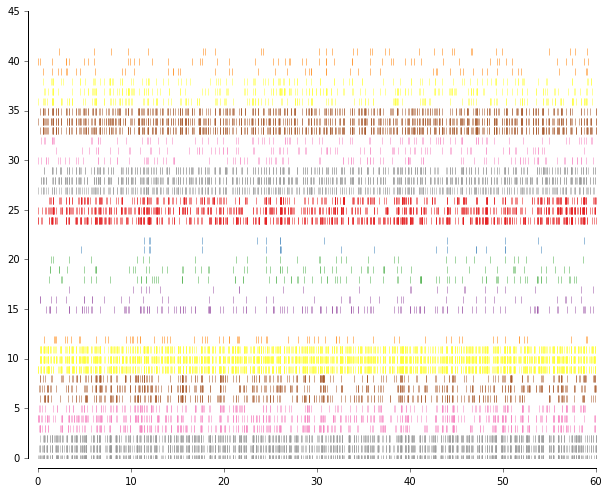

In [197]:
ax = plt.gca()
bmap = brewer2mpl.get_map('Set1', 'Qualitative', 9, reverse=True)
colors = bmap.mpl_colors

# structured stimuli
first_trial = 1
num_diff_trials = 8
total_trials = 24
num_repeats = 3
for c in range(len(cells)):
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][c])

    all_spikes, all_labels = spikes_to_array(repeats)
    all_labels += num_repeats * c
    
    # plot raster for this particular cell
    which_color = c % 9
    ax.plot(all_spikes, all_labels, '|', markersize=7, color=colors[which_color])

plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0, 60])

# Check out the STAs for the 14 cells

In [198]:
# cell_idx = 0
# first_trial = 7
# num_diff_trials = 8
# total_trials = 24

stas = []

whitenoise_expts = range(0,24,8)
for c in range(len(cells)):
    partial_sta = np.zeros((40, 50, 50))
    for expt_id in whitenoise_expts:
        expt_name = 'expt%d' %(expt_id+1)
        time = f[expt_name + '/timestamps']
        stimulus = f[expt_name + '/stim']
        sta, tax = ft.getsta(time, stimulus, expt_spikes[expt_id][c], 40)
        partial_sta += sta
    partial_sta /= len(whitenoise_expts)
    stas.append(partial_sta)

In [199]:
len(stas)

14

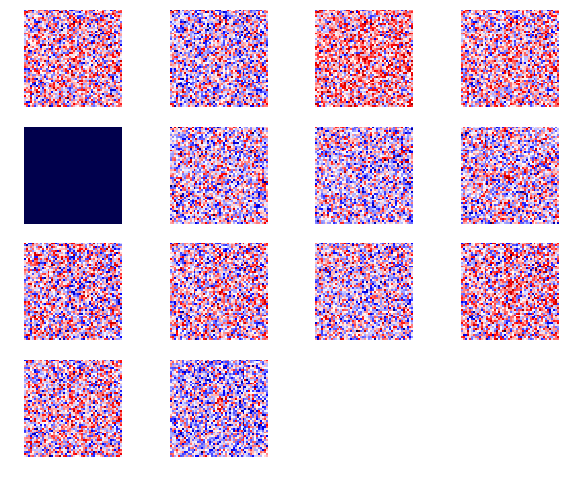

In [202]:
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            try:
                space, time = ft.decompose(stas[plt_idx-1])
            except:
                space = np.zeros((50,50))

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.imshow(space - np.mean(space), cmap='seismic')
            plt.axis('off')

#### save STAs

In [203]:
from deepretina.visualizations import visualize_sta

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [206]:
for c in range(len(cells)):
    try:
        space, time = ft.decompose(stas[c])
    except:
        space = np.zeros((50,50))
    plt.imshow(space - np.mean(space), cmap='seismic')
    plt_filename = 'sta_cell_%d.png' %(c)
    plt.savefig(plt_filename)
    plt.close()